In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("Monthly Rainfall Index and Flood Probability Kerala.csv")

df.head()

,SUBDIVISION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL RAINFALL,FLOODS
0,KERALA,1901,28.7,44.7,51.6,160.0,174.7,824.6,743.0,357.5,197.7,266.9,350.8,48.4,3248.6,YES
1,KERALA,1902,6.7,2.6,57.3,83.9,134.5,390.9,1205.0,315.8,491.6,358.4,158.3,121.5,3326.6,YES
2,KERALA,1903,3.2,18.6,3.1,83.6,249.7,558.6,1022.5,420.2,341.8,354.1,157.0,59.0,3271.2,YES
3,KERALA,1904,23.7,3.0,32.2,71.5,235.7,1098.2,725.5,351.8,222.7,328.1,33.9,3.3,3129.7,YES
4,KERALA,1905,1.2,22.3,9.4,105.9,263.3,850.2,520.5,293.6,217.2,383.5,74.4,0.2,2741.6,NO


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SUBDIVISION       118 non-null    object 
 1   YEAR              118 non-null    int64  
 2   JAN               118 non-null    float64
 3   FEB               118 non-null    float64
 4   MAR               118 non-null    float64
 5   APR               118 non-null    float64
 6   MAY               118 non-null    float64
 7   JUN               118 non-null    float64
 8   JUL               118 non-null    float64
 9   AUG               118 non-null    float64
 10  SEP               118 non-null    float64
 11  OCT               118 non-null    float64
 12  NOV               118 non-null    float64
 13  DEC               118 non-null    float64
 14   ANNUAL RAINFALL  118 non-null    float64
 15  FLOODS            118 non-null    object 
dtypes: float64(13), int64(1), object(2)
memory u

In [4]:
df['FLOODS'] = df['FLOODS'].replace('YES', 1)
df['FLOODS'] = df['FLOODS'].replace('NO', 0)
df.drop(['SUBDIVISION', ' ANNUAL RAINFALL'], axis=1, inplace=True)

In [5]:
df.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,FLOODS
0,1901,28.7,44.7,51.6,160.0,174.7,824.6,743.0,357.5,197.7,266.9,350.8,48.4,1
1,1902,6.7,2.6,57.3,83.9,134.5,390.9,1205.0,315.8,491.6,358.4,158.3,121.5,1
2,1903,3.2,18.6,3.1,83.6,249.7,558.6,1022.5,420.2,341.8,354.1,157.0,59.0,1
3,1904,23.7,3.0,32.2,71.5,235.7,1098.2,725.5,351.8,222.7,328.1,33.9,3.3,1
4,1905,1.2,22.3,9.4,105.9,263.3,850.2,520.5,293.6,217.2,383.5,74.4,0.2,0


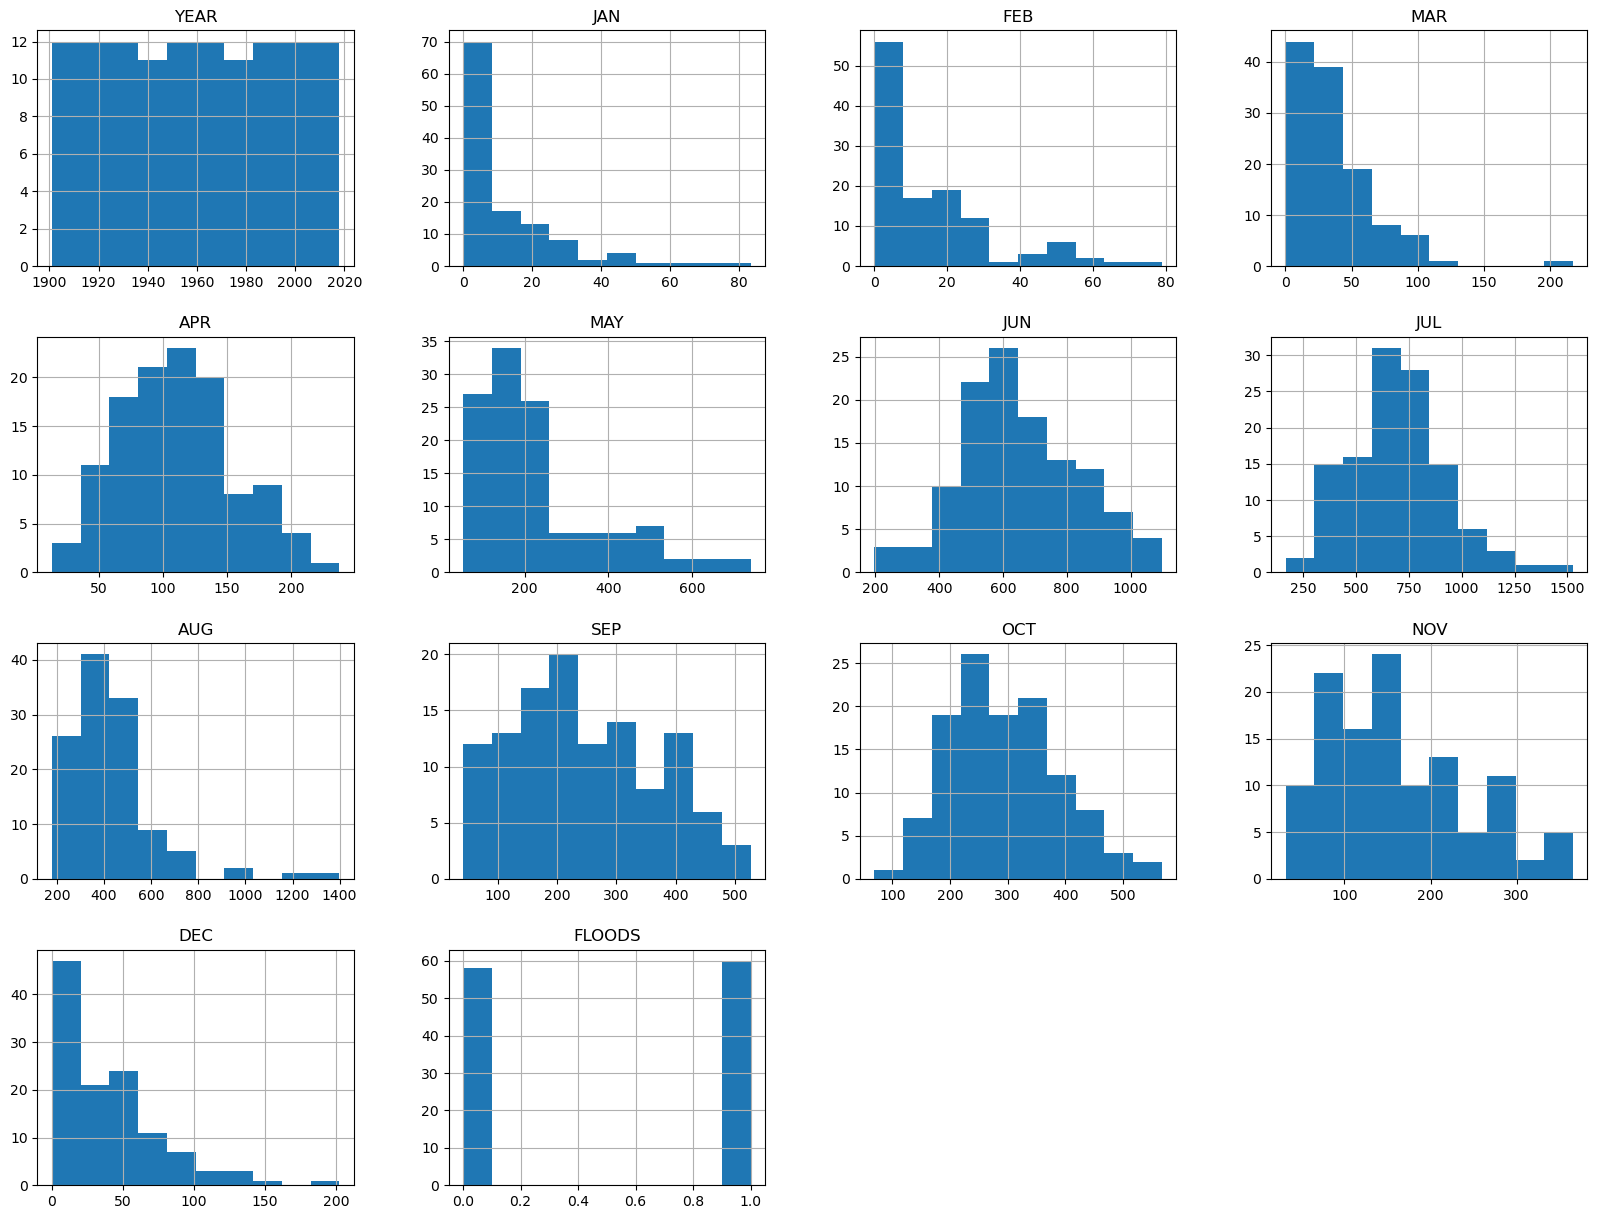

In [6]:
df.hist(bins=10, figsize=(20,15))
plt.show()

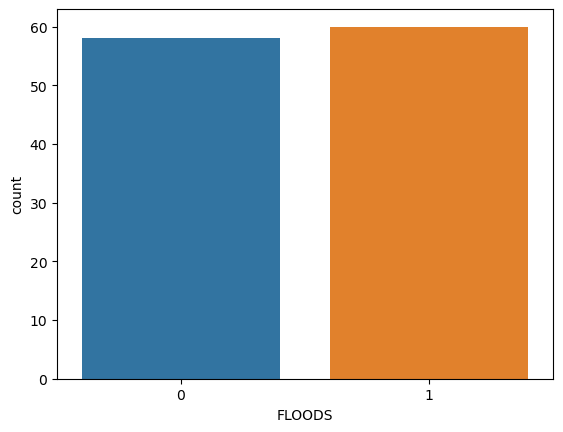

In [7]:
sns.countplot(data=df,x='FLOODS')
plt.show()

In [8]:
corr_matrix = df.corr()
corr_matrix['FLOODS'].sort_values(ascending=False)

FLOODS    1.000000
JUL       0.442774
JUN       0.442531
SEP       0.376385
AUG       0.286690
MAY       0.242813
NOV       0.238852
JAN       0.145313
MAR       0.086739
OCT       0.060088
DEC       0.054326
APR       0.034392
FEB      -0.035730
YEAR     -0.202548
Name: FLOODS, dtype: float64

<AxesSubplot:>

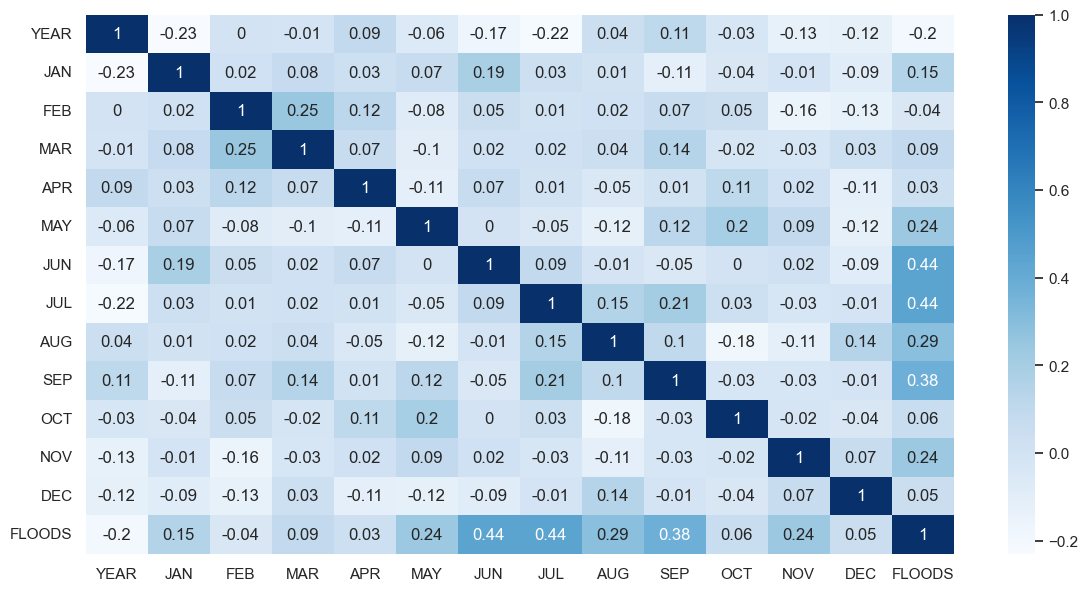

In [9]:
corr_matrix = df.corr().round(2)
sns.set(font_scale=1)
plt.figure(figsize = (14,7))
sns.heatmap(corr_matrix, annot = True, cmap='Blues')

In [165]:
X = df.iloc[:, 1:-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

std_scaler = StandardScaler()

X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

In [166]:
import tensorflow as tf
from tensorflow import keras

from keras.optimizers import Adam
from keras import layers
from keras.models import Sequential

In [167]:
def model_builder(hp):
    model = Sequential()

    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
    hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=14, step=1)
    hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=101, step=1)
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])

    model.add(layers.Dense(units=hp_layer_1, activation=hp_activation))
    model.add(layers.Dense(units=hp_layer_2, activation=hp_activation))
    model.add(layers.Dense(units=1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

    return model

In [168]:
import keras_tuner as kt

In [184]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='dir',
    overwrite=True
)

In [185]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [186]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.1, callbacks=[stop_early])

Trial 90 Complete [00h 00m 02s]
val_accuracy: 0.5

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 03m 35s
INFO:tensorflow:Oracle triggered exit


In [187]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [188]:
model =  tuner.hypermodel.build(best_hyperparameters)

history = model.fit(X_train, y_train, epochs=50, validation_split=0.1, callbacks=[stop_early])

Epoch 1/50
3/3 [==============================] - 1s 176ms/step - loss: 0.6524 - accuracy: 0.6190 - val_loss: 0.5541 - val_accuracy: 0.9000
Epoch 2/50
3/3 [==============================] - 0s 27ms/step - loss: 0.4971 - accuracy: 0.8690 - val_loss: 0.4582 - val_accuracy: 0.9000
Epoch 3/50
3/3 [==============================] - 0s 27ms/step - loss: 0.3978 - accuracy: 0.9048 - val_loss: 0.3692 - val_accuracy: 0.9000
Epoch 4/50
3/3 [==============================] - 0s 27ms/step - loss: 0.3127 - accuracy: 0.9524 - val_loss: 0.2884 - val_accuracy: 0.9000
Epoch 5/50
3/3 [==============================] - 0s 27ms/step - loss: 0.2436 - accuracy: 0.9524 - val_loss: 0.2184 - val_accuracy: 0.9000
Epoch 6/50
3/3 [==============================] - 0s 27ms/step - loss: 0.1837 - accuracy: 0.9524 - val_loss: 0.1845 - val_accuracy: 0.9000
Epoch 7/50
3/3 [==============================] - 0s 28ms/step - loss: 0.1390 - accuracy: 0.9524 - val_loss: 0.1636 - val_accuracy: 0.9000
Epoch 8/50
3/3 [==========

In [189]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.652449,0.619048,0.554081,0.9
1,0.497104,0.869048,0.458174,0.9
2,0.397796,0.904762,0.369179,0.9
3,0.312667,0.952381,0.288385,0.9
4,0.243614,0.952381,0.218385,0.9
5,0.183745,0.952381,0.184541,0.9
6,0.139002,0.952381,0.163593,0.9
7,0.104104,0.988095,0.164967,0.9
8,0.078325,0.988095,0.171197,0.9
9,0.057081,1.000000,0.201945,0.9


In [190]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 14)                182       
                                                                 
 dense_4 (Dense)             (None, 23)                345       
                                                                 
 dense_5 (Dense)             (None, 1)                 24        
                                                                 
Total params: 551
Trainable params: 551
Non-trainable params: 0
_________________________________________________________________


In [198]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 36ms/step


In [199]:
y_pred = (y_pred>0.5)

y_pred = y_pred.reshape(-1)

y_pred = y_pred.astype(int)

In [200]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

<AxesSubplot:>

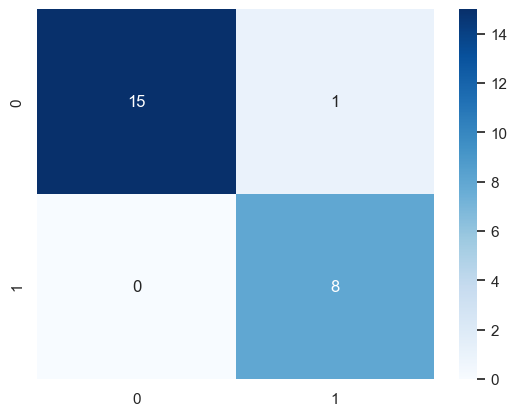

In [201]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

In [202]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.89      1.00      0.94         8

    accuracy                           0.96        24
   macro avg       0.94      0.97      0.95        24
weighted avg       0.96      0.96      0.96        24



In [203]:
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))

Accuracy Score:  0.9583333333333334
F1 Score:  0.9411764705882353


In [204]:
model.save('flood_prediction_model.h5')

In [205]:
# new_model = keras.models.load_model('flood_prediction_model.h5')

---

## Time Series Model

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import sklearn
assert sklearn.__version__ >= "0.20"

from time import time
import os

from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from sklearn import model_selection

import itertools
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace import sarimax as SARIMAX
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from pmdarima import auto_arima

import warnings
warnings.filterwarnings('ignore')

In [2]:
df1 = pd.read_csv("Monthly Rainfall Index Kerala Time Series.csv", index_col="Date", parse_dates=True)

df1.head()

,Rainfall(mm)
Date,
1901-01-01,28.7
1901-02-01,44.7
1901-03-01,51.6
1901-04-01,160.0
1901-05-01,174.7


In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1416 entries, 1901-01-01 to 2018-12-01
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rainfall(mm)  1416 non-null   float64
dtypes: float64(1)
memory usage: 22.1 KB


In [4]:
df1.describe()

,Rainfall(mm)
count,1416.000000
mean,243.786794
std,258.398667
min,0.000000
25%,35.275000
50%,154.700000
75%,371.350000
max,1526.500000


In [5]:
train = df1.iloc[:-36, :]
test = df1.iloc[-36:, :]

### Time Series Analysis

<AxesSubplot:xlabel='Date'>

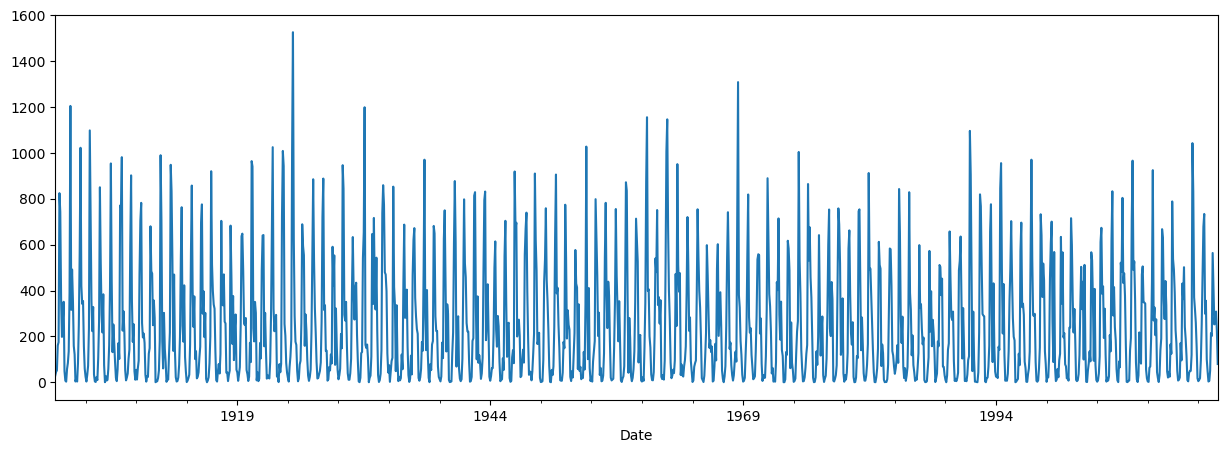

In [6]:
plt.figure(figsize=(15,5))
train['Rainfall(mm)'].plot()

### Stationarity Test

In [7]:
# Function to test the stationarity
def stationarity_test(ts):
    
    # Determining rolling statistics
    rolling_mean = ts.rolling(window=12).mean()
    rolling_std = ts.rolling(window=12).std()

    # Plotting rolling statistics:
    original = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show()
    
    # Performing Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    adfuller_test = adfuller(ts, autolag='AIC')
    print('ADF Statistic: %f' % adfuller_test[0])
    print('p-value: %f' % adfuller_test[1])
    print('Critical Values:')
    for key, value in adfuller_test[4].items():
           print(key, value)

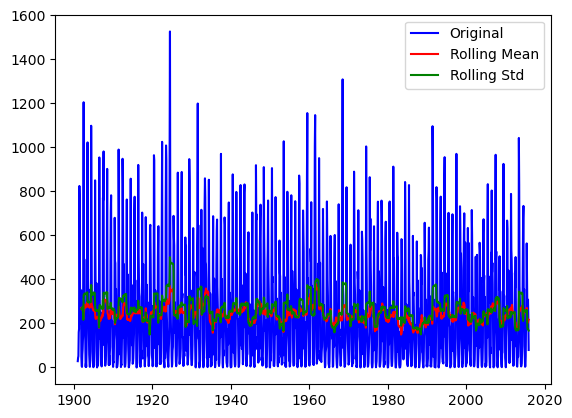

Results of Dickey-Fuller Test:
ADF Statistic: -5.631022
p-value: 0.000001
Critical Values:
1% -3.4351852261663867
5% -2.863675384893896
10% -2.5679068804891


In [8]:
stationarity_test(train['Rainfall(mm)'])

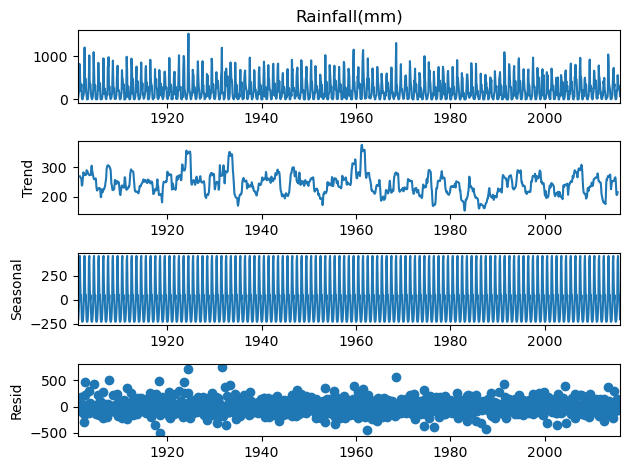

In [9]:
seasonal_decomposition = seasonal_decompose(train['Rainfall(mm)'], period = 12).plot()
plt.show()

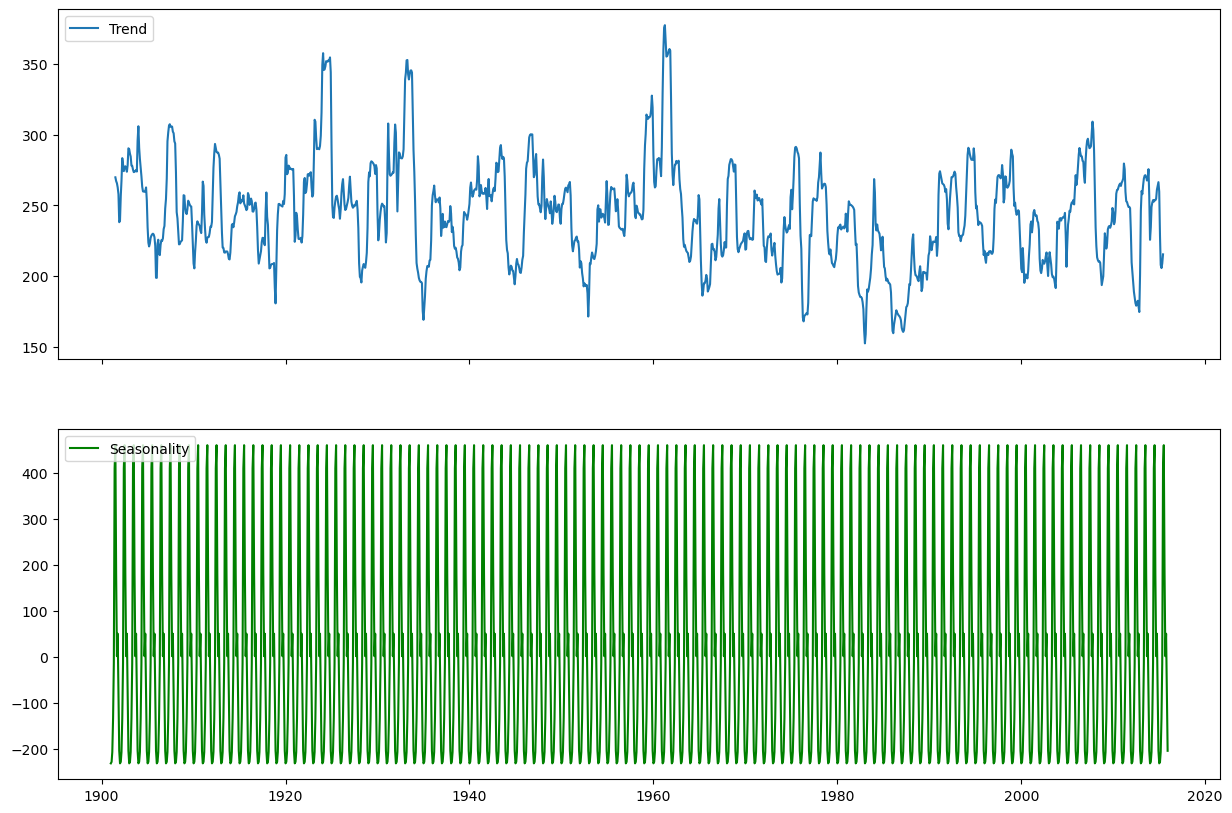

In [10]:
seasonal_decomposition = seasonal_decompose(train, period = 12)

train_trend = seasonal_decomposition.trend
train_seasonal = seasonal_decomposition.seasonal

fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[1].plot(train_seasonal, 'g', label='Seasonality')
axes[1].legend(loc='upper left')

axes[0].plot(train_trend, label='Trend')
axes[0].legend(loc='upper left')


In [12]:
# train_residual = seasonal_decomposition.resid
# train_residual = train_residual.dropna()
# stationarity_test(train_residual)

Text(0.5, 1.0, 'PACF')

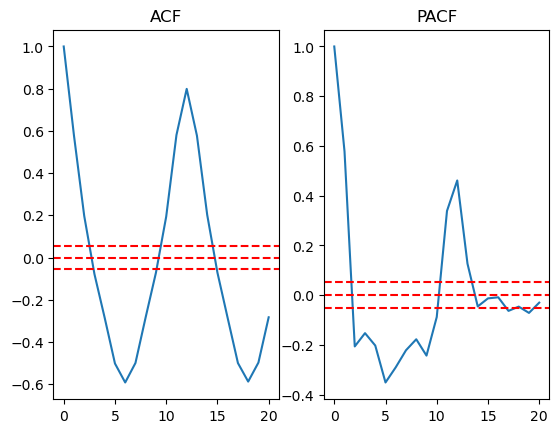

In [11]:
lag_acf = acf(train,nlags=20)
lag_pacf = pacf(train,nlags=20,method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color ='red')
plt.axhline(y=1.96/np.sqrt(len(train)),linestyle='--',color ='red')
plt.axhline(y=-1.96/np.sqrt(len(train)),linestyle='--',color ='red')
plt.title('ACF')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color ='red')
plt.axhline(y=1.96/np.sqrt(len(train)),linestyle='--',color ='red')
plt.axhline(y=-1.96/np.sqrt(len(train)),linestyle='--',color ='red')
plt.title('PACF')

In [35]:
model = auto_arima(y=train, m= 12)

c:\Users\jishn\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(0,0,0)(2,0,1)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "c:\Users\jishn\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "c:\Users\jishn\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 597, in fit
    self._fit(y, X, **fit_args)
  File "c:\Users\jishn\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 518, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "c:\Users\jishn\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 508, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,
  File "c:\Users\jishn\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 704, in fit
    mlefit = super(MLEModel, self).fit(start_para

In [37]:
predictions = pd.Series(model.predict(n_periods= len(test)))
predictions.index = test.index

predictions.head()

Date
2016-01-01     16.893491
2016-02-01     25.872624
2016-03-01     52.492855
2016-04-01    134.549273
2016-05-01    194.949963
dtype: float64

<AxesSubplot:xlabel='Date'>

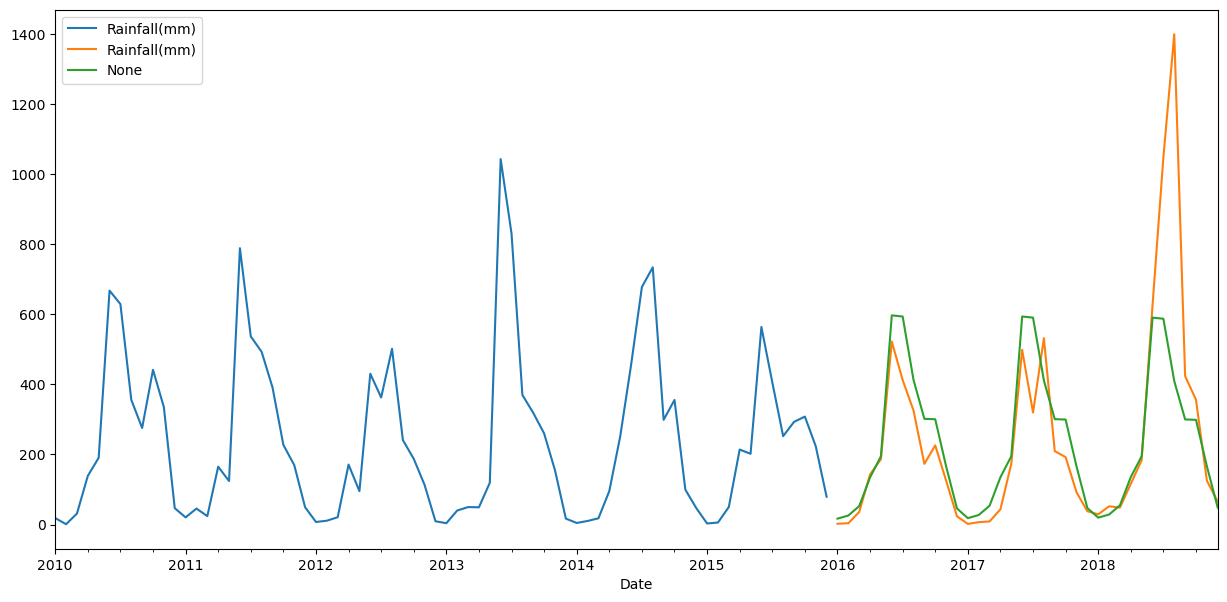

In [40]:
train['Rainfall(mm)']['2010-01-01':].plot(figsize=(15,7), legend=True)
test['Rainfall(mm)'].plot(legend=True)
predictions.plot(legend=True)

<AxesSubplot:xlabel='Date'>

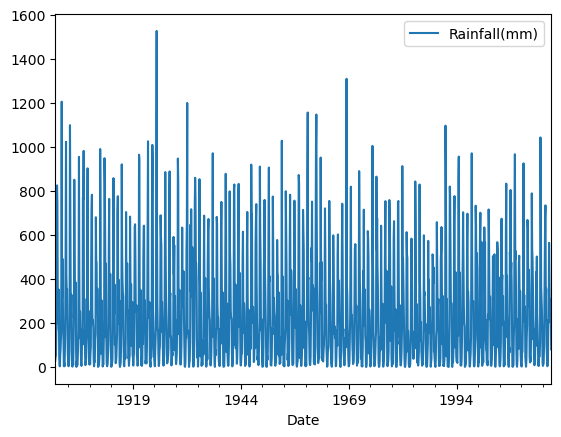

In [17]:
# Summing sales on per week basis
train_sarima = train.resample("MS").mean() 
train_sarima = train_sarima[["Rainfall(mm)"]]
train_sarima.plot()

In [18]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [21]:
min_aic = 10**10
min_pdq = None
min_s_pdq = None

for val in pdq:
    for val_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_sarima,
                                            order=val,
                                            seasonal_order=val_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            if (results.aic <= min_aic):
                min_aic = results.aic
                min_pdq = val
                min_s_pdq = val_seasonal
                # print('SARIMA:{}x{} - AIC:{}'.format(val, val_seasonal, results.aic))

        except:
            continue

In [22]:
#  SARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:16817.862622135865
print('SARIMA:{}x{} - AIC:{}'.format(min_pdq, min_s_pdq, min_aic))

SARIMA:(0, 1, 1)x(1, 1, 1, 12) - AIC:16817.862622135865


In [23]:
sarima_model = sm.tsa.statespace.SARIMAX(
    train_sarima,
    order=(0, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_sarima = sarima_model.fit()

print(results_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9958      0.005   -211.890      0.000      -1.005      -0.987
ar.S.L12       0.0479      0.019      2.553      0.011       0.011       0.085
ma.S.L12      -1.0197      0.009   -119.618      0.000      -1.036      -1.003
sigma2      1.362e+04    325.844     41.796      0.000     1.3e+04    1.43e+04


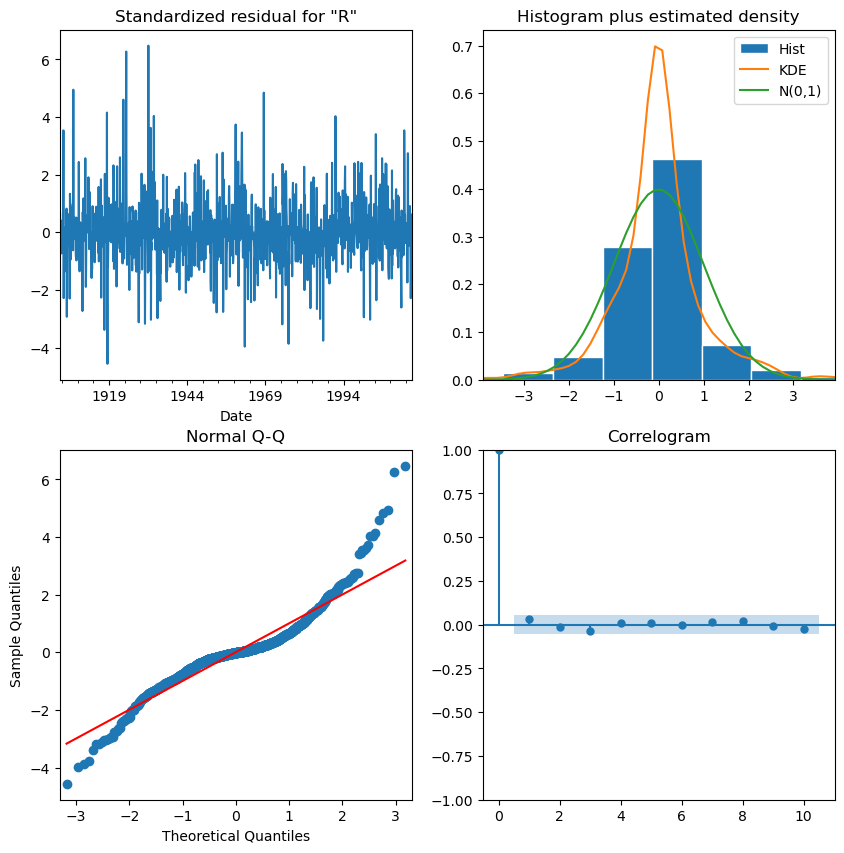

In [24]:
results_sarima.plot_diagnostics(figsize=(10, 10))
plt.show()

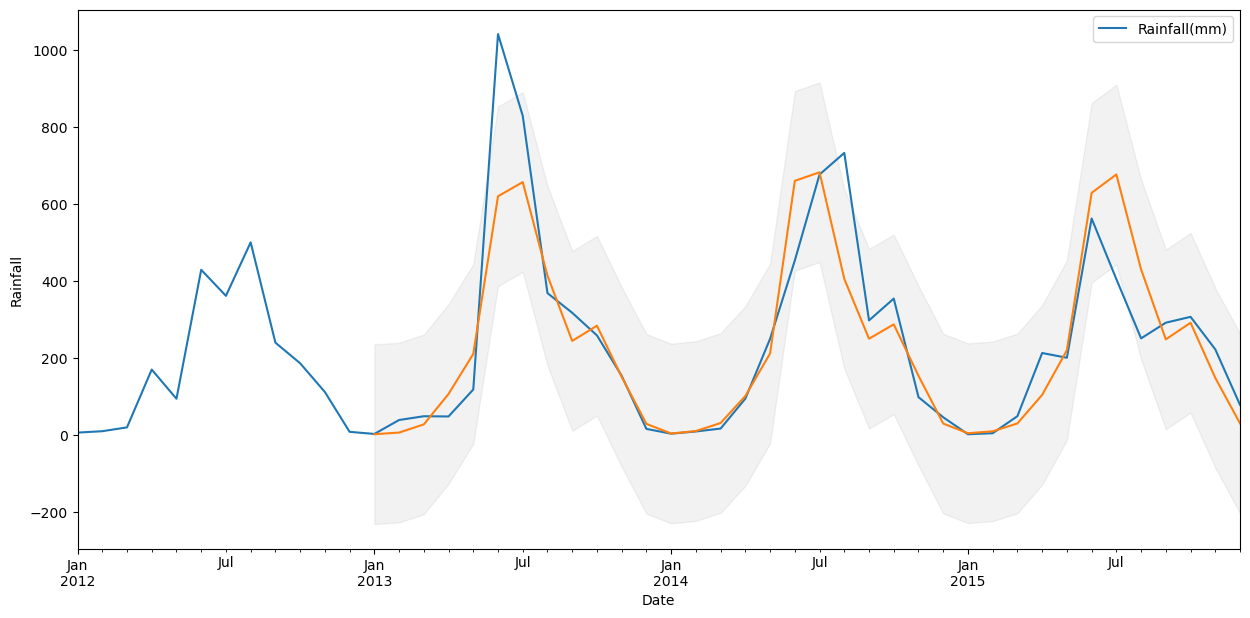

Root Mean Squared Error:  120.59713541491737


In [60]:
# Model Prediction and validation 
# Predictions are performed for the 11th Jan' 2015 onwards of the train data.

pred = results_sarima.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic = False) 

# Get confidence intervals of forecasts
pred_ci = pred.conf_int() 

ax = train_sarima["2012":].plot(label="observed", figsize=(15, 7))
pred.predicted_mean.plot(ax = ax, label="One-step ahead Forecast", alpha = 1)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], 
                color = "k", alpha = 0.05)

ax.set_xlabel("Date")
ax.set_ylabel("Rainfall")

plt.legend
plt.show()

train_sarima_forecasted = pred.predicted_mean
train_sarima_truth = train_sarima["2013-01-01":]

# Calculating the error
rmse_sarima = sqrt(mean_squared_error(train_sarima_truth, train_sarima_forecasted))
print("Root Mean Squared Error: ", rmse_sarima)

In [50]:
predictions = pd.Series(results_sarima.predict(start=len(train), end=len(train)+len(test)-1))
predictions.index = test.index

predictions.head()

Date
2016-01-01      4.527623
2016-02-01      9.289705
2016-03-01     32.006541
2016-04-01    111.973176
2016-05-01    216.984852
Name: predicted_mean, dtype: float64

Root Mean Squared Error:  199.16301655499558


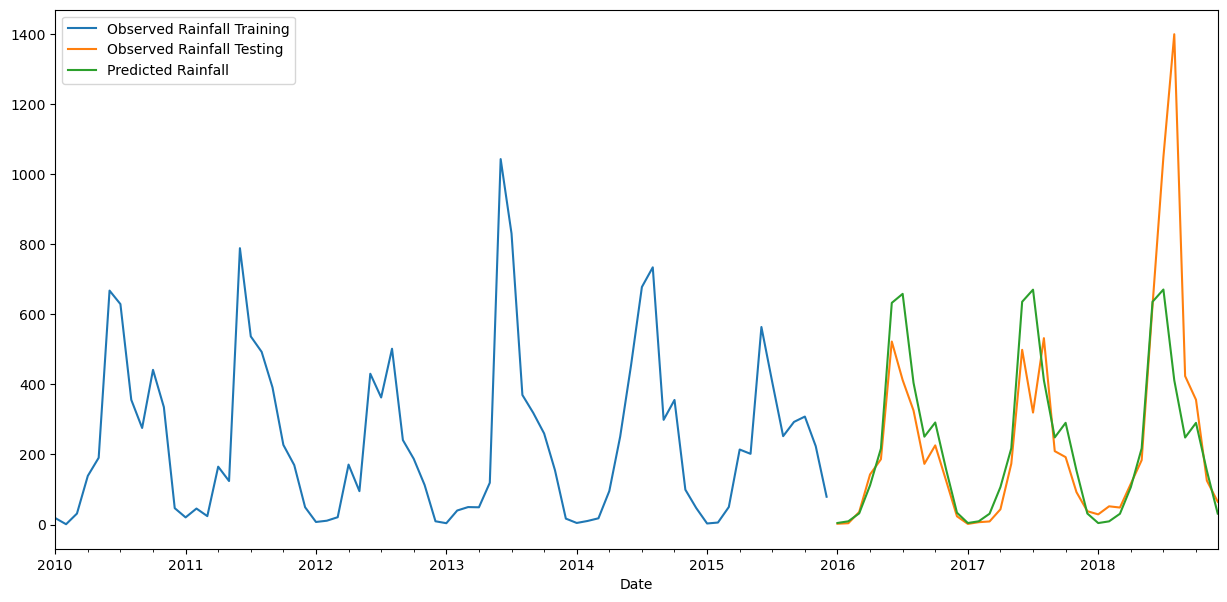

In [52]:
train['Rainfall(mm)']['2010-01-01':].plot(figsize=(15,7), legend=True, label="Observed Rainfall Training")
test['Rainfall(mm)'].plot(legend=True, label="Observed Rainfall Testing")
predictions.plot(legend=True, label="Predicted Rainfall")


test_sarima_forecasted = predictions
test_sarima_truth = test

# Calculating the error
rmse_sarima = sqrt(mean_squared_error(test_sarima_truth, test_sarima_forecasted))
print("Root Mean Squared Error: ", rmse_sarima)

In [59]:
results_sarima.predict(start=len(train)+len(test)+48, end=len(train)+len(test)+60-1)

2023-01-01      3.543027
2023-02-01      8.408823
2023-03-01     30.040114
2023-04-01    105.780216
2023-05-01    216.692187
2023-06-01    634.894642
2023-07-01    669.834795
2023-08-01    411.095635
2023-09-01    247.606482
2023-10-01    289.333027
2023-11-01    152.860207
2023-12-01     30.509183
Freq: MS, Name: predicted_mean, dtype: float64